<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving Dataload.py to Dataload.py
Saving F1_test.py to F1_test.py
Saving kaggle.json to kaggle.json
Saving main.py to main.py
Saving main_notebook.ipynb to main_notebook.ipynb
Saving models.py to models.py
Saving README.md to README.md
Saving requirements.txt to requirements.txt
Saving test_labels_captions.csv to test_labels_captions.csv
Saving train_labels_captions.csv to train_labels_captions.csv
Saving utils.py to utils.py


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

 96% 383M/399M [00:02<00:00, 137MB/s] 
100% 399M/399M [00:02<00:00, 161MB/s]


We are using GPU.
Model initialized.


  0%|          | 0/10 [00:00<?, ?it/s]


Train Epoch: 0 [0/20998 (0%)]	Loss: 0.692462

Train Epoch: 0 [6400/20998 (30%)]	Loss: 0.319567

Train Epoch: 0 [12800/20998 (61%)]	Loss: 0.255780

Train Epoch: 0 [19200/20998 (91%)]	Loss: 0.286539


 10%|█         | 1/10 [00:56<08:28, 56.48s/it]


Train Epoch: 1 [0/20998 (0%)]	Loss: 0.282733

Train Epoch: 1 [6400/20998 (30%)]	Loss: 0.198881

Train Epoch: 1 [12800/20998 (61%)]	Loss: 0.240912

Train Epoch: 1 [19200/20998 (91%)]	Loss: 0.224668


 20%|██        | 2/10 [01:50<07:20, 55.00s/it]


Train Epoch: 2 [0/20998 (0%)]	Loss: 0.224314

Train Epoch: 2 [6400/20998 (30%)]	Loss: 0.191771

Train Epoch: 2 [12800/20998 (61%)]	Loss: 0.193441

Train Epoch: 2 [19200/20998 (91%)]	Loss: 0.187316


 30%|███       | 3/10 [02:48<06:34, 56.35s/it]


Train Epoch: 3 [0/20998 (0%)]	Loss: 0.183791

Train Epoch: 3 [6400/20998 (30%)]	Loss: 0.168109

Train Epoch: 3 [12800/20998 (61%)]	Loss: 0.176761

Train Epoch: 3 [19200/20998 (91%)]	Loss: 0.165883


 40%|████      | 4/10 [03:42<05:32, 55.42s/it]


Train Epoch: 4 [0/20998 (0%)]	Loss: 0.155732

Train Epoch: 4 [6400/20998 (30%)]	Loss: 0.197005

Train Epoch: 4 [12800/20998 (61%)]	Loss: 0.153783

Train Epoch: 4 [19200/20998 (91%)]	Loss: 0.187599


 50%|█████     | 5/10 [04:36<04:35, 55.11s/it]


Train Epoch: 5 [0/20998 (0%)]	Loss: 0.192186

Train Epoch: 5 [6400/20998 (30%)]	Loss: 0.164356

Train Epoch: 5 [12800/20998 (61%)]	Loss: 0.188937

Train Epoch: 5 [19200/20998 (91%)]	Loss: 0.218521


 60%|██████    | 6/10 [05:31<03:39, 54.90s/it]


Train Epoch: 6 [0/20998 (0%)]	Loss: 0.201228

Train Epoch: 6 [6400/20998 (30%)]	Loss: 0.153796

Train Epoch: 6 [12800/20998 (61%)]	Loss: 0.185331

Train Epoch: 6 [19200/20998 (91%)]	Loss: 0.192529


 70%|███████   | 7/10 [06:24<02:43, 54.39s/it]


Train Epoch: 7 [0/20998 (0%)]	Loss: 0.162296

Train Epoch: 7 [6400/20998 (30%)]	Loss: 0.145399

Train Epoch: 7 [12800/20998 (61%)]	Loss: 0.184040

Train Epoch: 7 [19200/20998 (91%)]	Loss: 0.169144


 80%|████████  | 8/10 [07:17<01:48, 54.00s/it]


Train Epoch: 8 [0/20998 (0%)]	Loss: 0.158703

Train Epoch: 8 [6400/20998 (30%)]	Loss: 0.186660

Train Epoch: 8 [12800/20998 (61%)]	Loss: 0.184712

Train Epoch: 8 [19200/20998 (91%)]	Loss: 0.168619


 90%|█████████ | 9/10 [08:12<00:54, 54.15s/it]


Train Epoch: 9 [0/20998 (0%)]	Loss: 0.194675

Train Epoch: 9 [6400/20998 (30%)]	Loss: 0.166283

Train Epoch: 9 [12800/20998 (61%)]	Loss: 0.184331

Train Epoch: 9 [19200/20998 (91%)]	Loss: 0.165264


100%|██████████| 10/10 [09:06<00:00, 54.68s/it]


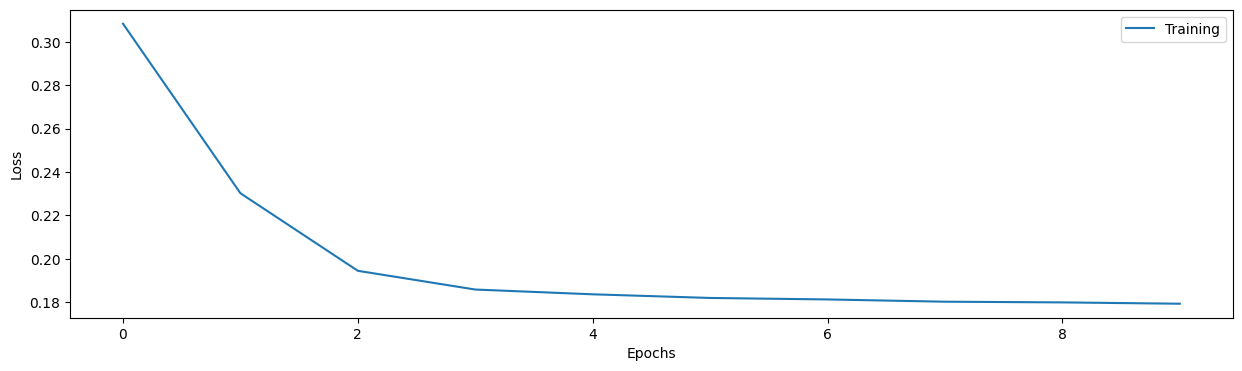

100%|██████████| 8998/8998 [00:33<00:00, 265.62it/s]


Test set results: Average loss: 0.1866, F1 Score: 0.59



In [5]:
import re
import pandas as pd
from io import StringIO
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split

from Dataload import pil_process_image_color, encode, CustomImageDataset
from models import CNN
from utils import test, train_network

from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 64
lr = 0.0001

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# To get overview
#print(df_test.describe)

# Defining transforms
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # Trying to resize to (INPUT_HEIGHT,INPUT_WIDTH)

# TODO: we can add data augmentation here
# See for example https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# or here: https://docs.pytorch.org/vision/main/transforms.html
trainTransforms = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.ToTensor()])
testTransforms = transforms.Compose([resize,transforms.ToTensor()])

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=encode)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Setup model
model = CNN().to(device)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print('Model initialized.')

# Creating 70/30 split of data
generator1 = torch.Generator().manual_seed(42)
subset_train,subset_test = random_split(training_data, [0.7, 0.3], generator=generator1)
subset_trainloader = DataLoader(subset_train, batch_size=batch_size, shuffle=True,drop_last=True)
subset_testloader = DataLoader(subset_test)

# Training
log_interval = 100 # How often we print train loss
train_losses = train_network(log_interval,model, device, subset_trainloader, optimizer, loss,epochs=10)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Testing forward operator
test(model, device, subset_testloader,loss)